# Fine‑Tuning SmolVLA for Vision‑Language Pick‑and‑Place

### Nihal Karim and Henry Hu


This project was an exploration of VLA (Vison, Language, Action) model, specifically SmolVLA - a lightweight 450M parameter model that can be run on local inference created by the HuggingFace LeRobot project. VLAs are generative models used in robotics to combine both computer vision inputs, with natural language commands to generate action inputs (usually motor control states) for different robots. Of course these are very difficult to generalize. LeRobot focuses on trying to do that, by creating a standardized robot controls and arms.

These designs combine transformer models on both vision (images and videos) and language (sentence-transformers etc.) and reinforcement learning to create very cutting-edge results.

In this project, we focused on buidling around simulation. Much time and effort was put into starting a SO101 arm setup, but due to lack of simulation experience, we were unable to get it functioning. We pivoted to using an already existing Franka Panda sim setup, on which we were able to get a dataset running and fine-tuned on to show some early model improvement.

# Model Overview

SmolVLA is a 450M parameter model that's small enough to run locally and trained on on public, community-shared data. It can be tested and deployed on affordable hardware such as SO-100, SO-101, and Lekiwi, etc.

## Model Architecture

The model has two main components: a Vision-Language Model (VLM) and an Action-Expert.

#### Vision-Language Model (VLM)
SmolVLM2 is the VLM backbone for SmolVLA. It consists of a SigLIP vision encoder and a SmolLM2 language decoder. In the VLM set up: 
- image tokens are extracted via the vision encoder
- language instructions are tokenzied and fed into the decoder
- sensorimotor states are projected into a single token (with the same dimension as the language model) with a linear layer

The process image, language and sensorimotor tokens are then concatenated before being passed into the action expert. The combined tokens form a high level plan_vector that will inform the action expert of its next steps.

#### Action Expert
The action expert is a transfomer with 100M parameters that generates action chunks for the robot arm. Utilizing flow matching, the action expert allows non-autoregresive prediction (meaning it produces a list of continuous actions as opposed to autoregressive prediction which predicts the very next action based on the previous actions), speeding up inference time. 

## Model Design Choices 

To ensure the model is lightweight and runnable on local hardware, the following design choices were made:

#### Visual Token Reduction

SmolVLA limits the number of visual tokens to 64 per frame with PixelShuffle, an efficient shuffling technique that let fewer visual tokens to represent the image. As a result, for a 512*512 image, the vision encoder takes only 64 tokens instead of 1024 (512 * 512 / (16 * 16)). Note that the underlying VLM is pre-trained using image tiling, but SmolVLA uses the global image at runtime.

#### VLM Layer Skipping

In SmolVLA, the action expert only attends to VLM features up to a configurable layer NN (set at half of the total layers), skipping the rest of the layers, as prior work has shown that early layers often provider better representations for downstream tasks. This halves the compute cost for the model and significantly speeds up inference. 

#### Interleaved Cross and Self-Attention

The action expert utilizes both cross and self-attention mechanism. It attends to VLM's features with cross-attention, while attending to its own features with self-attention (only to past action tokens). This allows for better performance, as cross-attention ensures that the actions are conditioned on the VLM plan, while self-attention improves temporal smoothness. 

#### Asynchronous Inference 

To prevent the robot arms to stall mid-task and wait for new action predictions, SmolVLA implements an asynchronous inference mechanism. When previous action queue falls below a threshold, inference will take place in parallel to generate a new action chunk. Any overlaping action chunks will be merged to form a continuous action sequence.

## Training Mechanism 

While the VLM component of the SmolVLA is pre-trained, the action expert is trained from scratch using the following flow matching objective. 

#### Data: A Trajectory of Plan Vectors and Actions

The training data consists of a sequence of plan vectors and action chunks:

- Time t: (image_t, instruction, robot_state_t) -> leads to -> action_t
- Time t+1: (image_t+1, instruction, robot_state_t+1) -> leads to -> action_t+1
- Time t+2: (image_t+2, instruction, robot_state_t+2) -> leads to -> action_t+2
- ...

#### Training with Flow Matching

1. Pick a Random Moment: randomly select a single point in time, t, from one of these trajectories. This gives us our input state: (image_t, instruction, robot_state_t)
2. Generate the Plan: this input state is fed into the VLM to output a single, high-level plan_vector for the action expert
3. Identify the "Ground Truth Future": identify the true actions performed starting from time t. Take the next arbitrary number of actions (e.g. 8). This becomes the ground truth target, action_true. action_true = [action_t, action_t+1, action_t+2, ..., action_t+7]. This action_true is a tensor of shape (8, 7), assuming 7 DOF for the robot arm. This is what the model is trying to restore to.

4. Perform Flow Matching:

    - create a random noise tensor action_noise of shape (8, 7)
    - corrupt the ground truth with the noise: action_intermediate = action_true + action_noise
    - feed the corrupted action sequence action_intermediate and the plan_vector into the action expert
    - the action expert will then predict the "correction vector" (also in the shape of (8, 7)) that would transform action_intermediate back into the perfect, ground-truth action_true

In inference, this correction vector, conditional on the plan_vector, is applied to a randomly generated noise vector to output the desired action sequence.  

# Disclaimer on Jupyter Notebook

The tools to run this project are not able to be run in jupyter notebook, as on Mac they require simulation tools (MuJoCo) and therefore run on mjpython (a modified python extension). It also utilizes much of the existing LeRobot architecture Also the finetuning was done on a Colab notebook to utilize GPU.

**This notebook is more an insturuction guide of what was done**

# Conda Env Setup

```bash
# First create a clean enviornment
conda create -y -n smolvla python=3.10
conda activate smolvla
# Clone the LeRobot Architecture
git clone https://github.com/huggingface/lerobot.git
cd lerobot
pip install -e ".[hilserl,smolvla]"
```

# Data Setup and Processing

Next a dataset needs to be created in sim - See this guide on how this dataset was created - https://huggingface.co/docs/lerobot/main/en/getting_started_real_world_robot#record-a-dataset

We used the existing sim dataset here - https://huggingface.co/datasets/AIResearcherHZ/pick_cube_rl

Note - we attempted modifying this dataset by adding an observation.instruction column - this may have led to better improvments in performance but we were unable to create this in time and proceeded with finetuning as is.

#### Attempted Data Processing (not currently implemented on current fine-tuned model)

In [ ]:
from datasets import load_dataset

# The instruction for every episode in this dataset
INSTRUCTION = "Pick up the cube."

print("Loading the dataset...")
# Load the original dataset
ds = load_dataset("AIResearcherHZ/pick_cube_rl", split="train")

def add_instruction_column(batch):
    # For every row in the batch, add a new key "task" with the instruction.
    # The dataloader will treat this as a new column.
    batch["task"] = [INSTRUCTION] * len(batch["episode_index"])
    return batch

print("Adding 'task' column to the dataset...")
# Use map to efficiently add the new column
ds = ds.map(
    add_instruction_column,
    batched=True,
    batch_size=128, # Process in batches for efficiency
)

print("Dataset processed. Here's an example from the new dataset:")
print(ds[0])

# Now, push the new dataset to the Hugging Face Hub.
new_repo_id = "karimnihal/pick_cube_il_instruct" 
print(f"Pushing new dataset to {new_repo_id}...")
ds.push_to_hub(new_repo_id)

print("Done!")

#### The dataset can be visualized here (https://huggingface.co/spaces/lerobot/visualize_dataset?path=%2FAIResearcherHZ%2Fpick_cube_rl%2Fepisode_0)

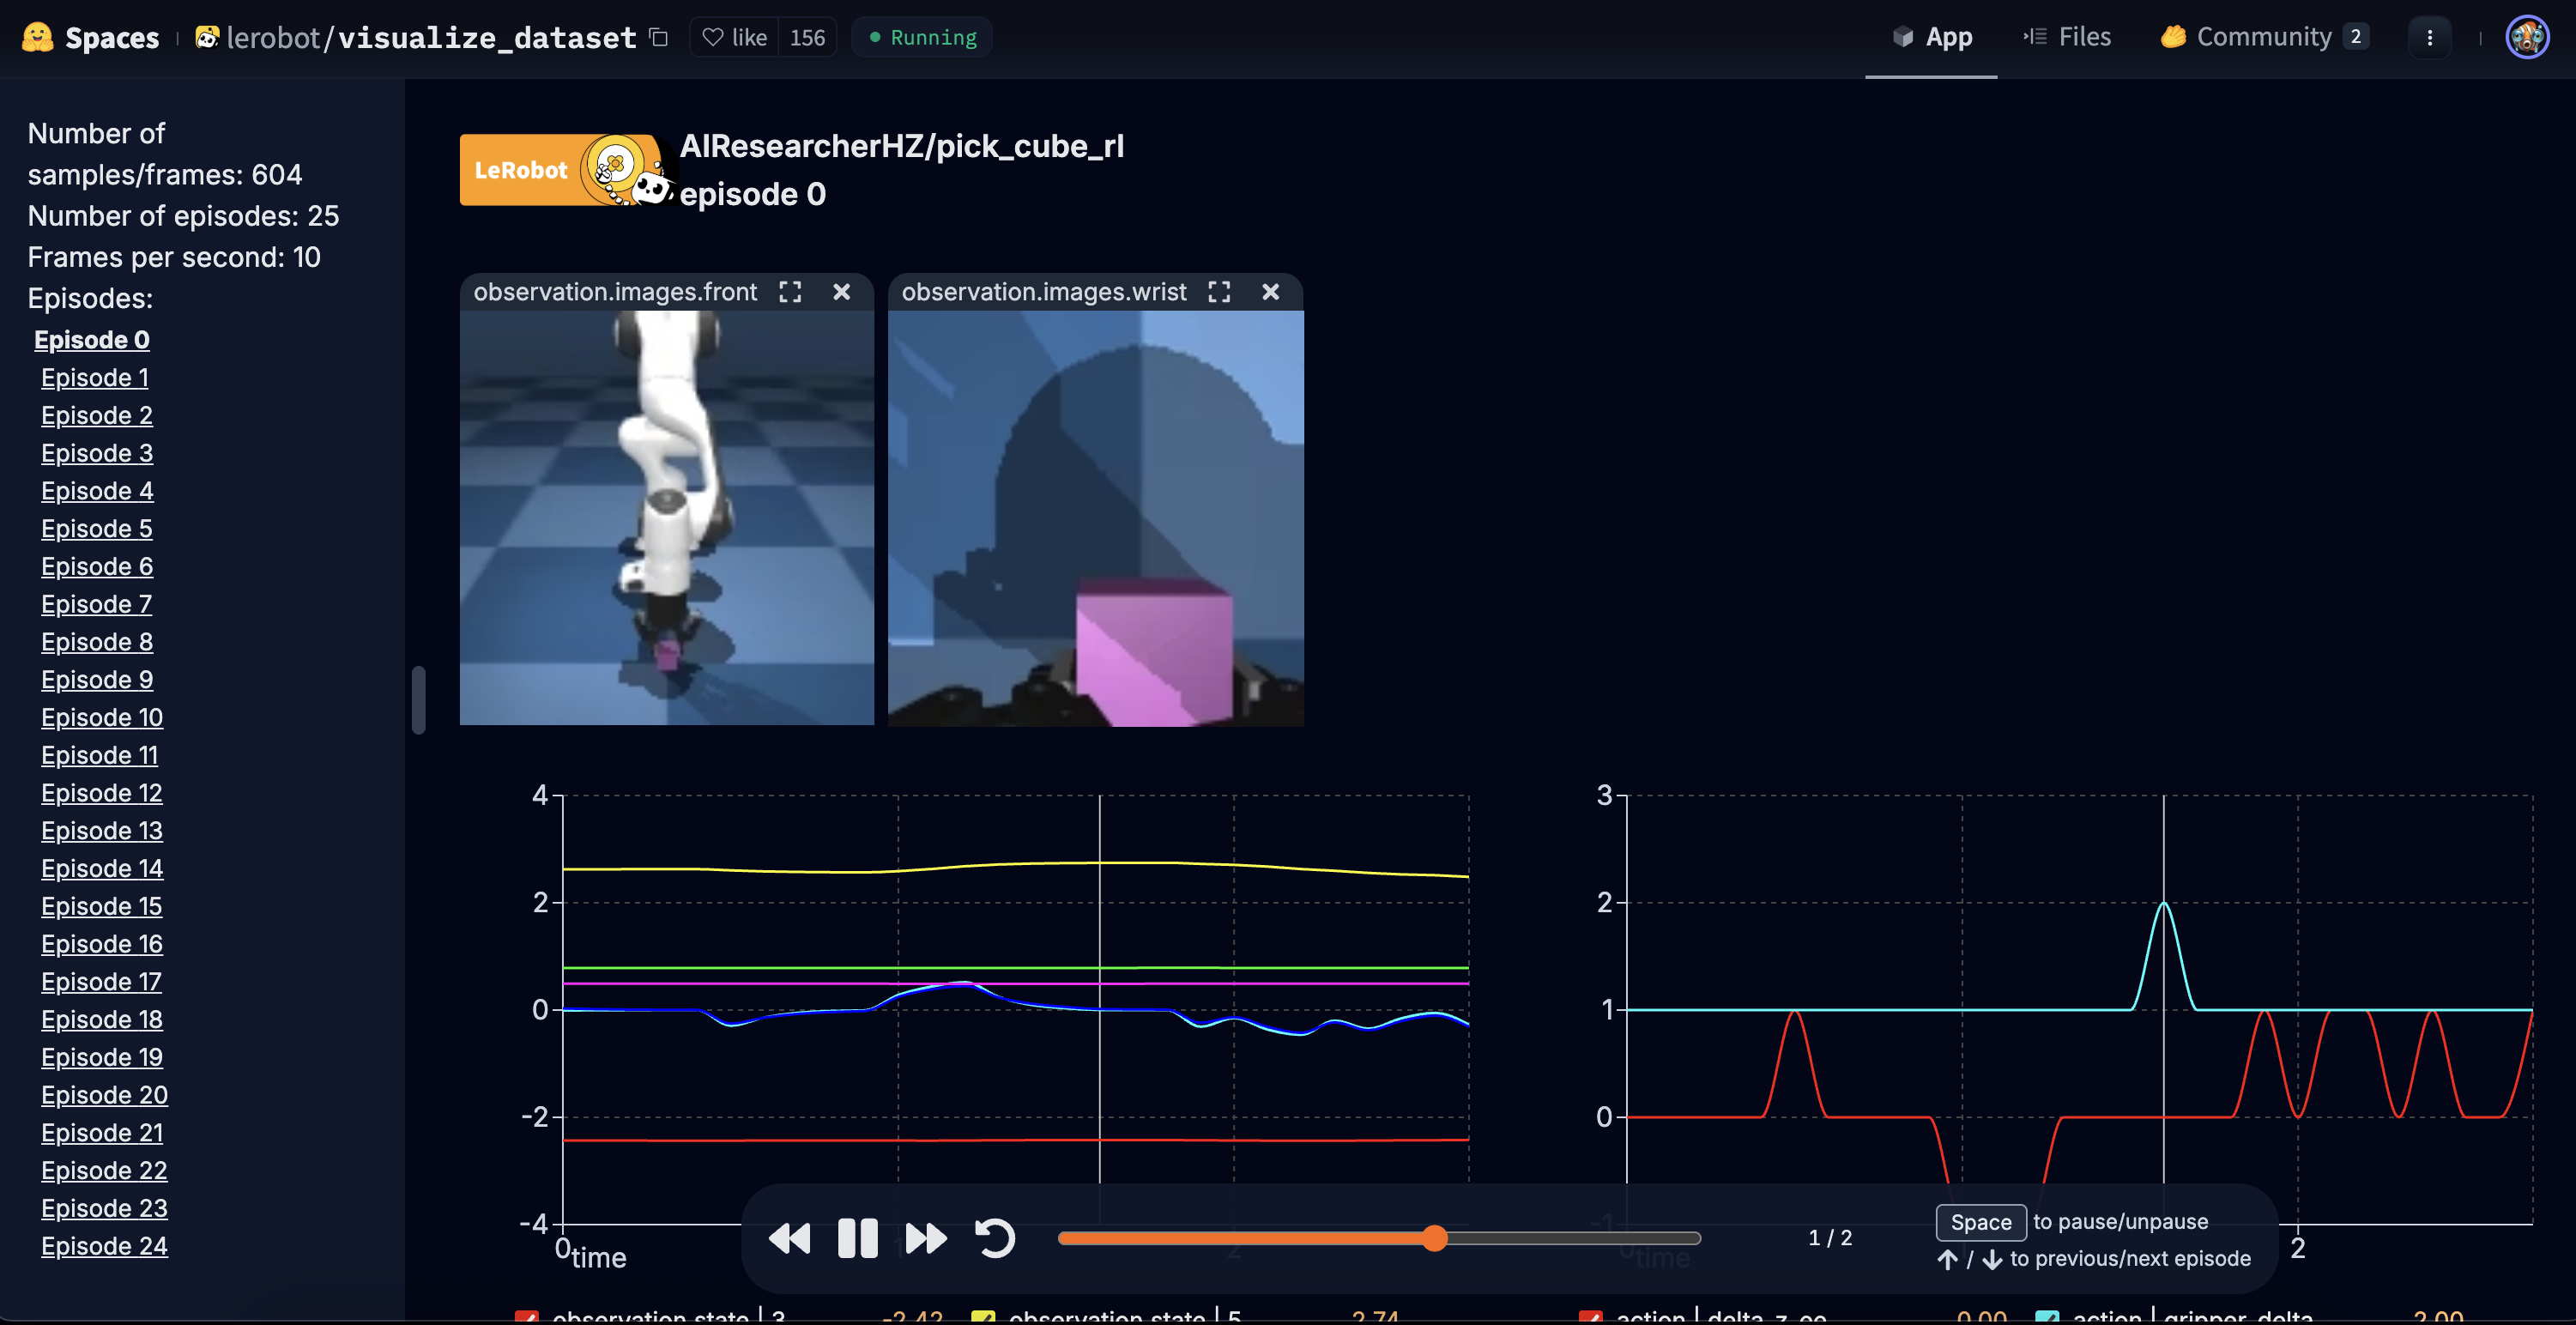

# Evaluation Setup

#### In order to utilize LeRobot tools for this purpose we must modify the setup. We updated lerobot/lerobot/scripts/rl/eval_policy.py

In [ ]:
# !/usr/bin/env python

# Copyright 2025 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import logging
import torch # Make sure torch is imported

from lerobot.common.cameras import opencv  # noqa: F401
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robots import (  # noqa: F401
    RobotConfig,
    make_robot_from_config,
    so100_follower,
)
from lerobot.common.teleoperators import (
    gamepad,  # noqa: F401
    so101_leader,  # noqa: F401
)
from lerobot.configs import parser
from lerobot.configs.train import TrainRLServerPipelineConfig
from lerobot.scripts.rl.gym_manipulator import make_robot_env

logging.basicConfig(level=logging.INFO)

# In lerobot/scripts/rl/eval_policy.py

def check_contact(env, body1_name, body2_names):
    """
    Checks if body1 is in contact with any of the bodies in body2_names
    using the modern Gymnasium MuJoCo API.

    Args:
        env: The wrapped Gymnasium environment.
        body1_name (str): The name of the first body (e.g., 'object').
        body2_names (list[str]): A list of names for the second set of bodies (e.g., ['hand_finger_left', 'hand_finger_right']).

    Returns:
        bool: True if contact is detected, False otherwise.
    """
    # Get the core environment, which has .model and .data attributes
    core_env = env.env.unwrapped
    model = core_env.model
    data = core_env.data

    # Get the integer IDs for the body names from the model
    try:
        body1_id = model.body(body1_name).id
    except KeyError:
        logging.warning(f"Body '{body1_name}' not found in model.")
        return False
        
    body2_ids = []
    for name in body2_names:
        try:
            body2_ids.append(model.body(name).id)
        except KeyError:
            logging.warning(f"Body '{name}' not found in model.")

    # Iterate through all contacts in the current simulation step using data
    for i in range(data.ncon):
        contact = data.contact[i]
        
        # Get the body IDs of the geoms in contact
        geom1_body_id = model.geom_bodyid[contact.geom1]
        geom2_body_id = model.geom_bodyid[contact.geom2]

        # Check for contact in both directions
        if (geom1_body_id == body1_id and geom2_body_id in body2_ids) or \
           (geom2_body_id == body1_id and geom1_body_id in body2_ids):
            return True
    return False

def eval_policy(env, policy, n_episodes):
    sum_reward_episode = []
    # New metric: Keep track of which episodes made contact
    contact_made_episode = []

    task_prompt = "Pick up the cube."
    device = next(policy.parameters()).device

    # Define the names of the bodies we want to check for contact
    CUBE_NAME = "block"
    GRIPPER_NAMES = ["left_pad", "right_pad", "left_silicone_pad", "right_silicone_pad"]

    for i in range(n_episodes):
        logging.info(f"--- Starting episode {i+1}/{n_episodes} ---")
        obs, _ = env.reset()
        episode_reward = 0.0
        # Flag to see if contact was made in this episode
        contact_this_episode = False
        policy.reset()
        
        while True:
            for key, value in obs.items():
                if isinstance(value, torch.Tensor):
                    obs[key] = value.to(device)
            
            obs["task"] = task_prompt
            action = policy.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            
            # Check for contact after the step is taken
            if not contact_this_episode and check_contact(env, CUBE_NAME, GRIPPER_NAMES):
                contact_this_episode = True
                logging.info("Contact with cube detected!")

            obs.pop("task", None) 
            episode_reward += reward
            
            if terminated or truncated:
                logging.info(f"Episode finished with reward: {episode_reward}")
                break
        
        sum_reward_episode.append(episode_reward)
        contact_made_episode.append(contact_this_episode)

    # --- New, more detailed reporting ---
    success_rate = sum(r > 0 for r in sum_reward_episode) / len(sum_reward_episode)
    contact_rate = sum(contact_made_episode) / len(contact_made_episode)
    
    logging.info("=" * 50)
    logging.info(f"EVALUATION SUMMARY OVER {n_episodes} EPISODES")
    logging.info("=" * 50)
    logging.info(f"Episode Rewards: {sum_reward_episode}")
    logging.info(f"Successful Episodes (reward > 0): {success_rate:.2%}")
    logging.info("-" * 50)
    logging.info(f"Contact Made (T/F): {contact_made_episode}")
    logging.info(f"Contact Rate: {contact_rate:.2%}")
    logging.info("=" * 50)

@parser.wrap()
def main(cfg: TrainRLServerPipelineConfig):
    env_cfg = cfg.env
    env = make_robot_env(env_cfg)
    dataset_cfg = cfg.dataset
    dataset = LeRobotDataset(repo_id=dataset_cfg.repo_id)
    dataset_meta = dataset.meta

    policy = make_policy(
        cfg=cfg.policy,
        # env_cfg=cfg.env,
        ds_meta=dataset_meta,
    )
    policy.from_pretrained(env_cfg.pretrained_policy_name_or_path)
    policy.eval()

    eval_policy(env, policy=policy, n_episodes=10)

if __name__ == "__main__":
    main()


#### In order to run LeRobot policy evaluation (action commands in Sim) - we must create a JSON config file

```bash
mkdir -p experiments/smolvla_eval
cd experiments/smolvla_eval
touch eval_config_smolvla.json
```

In [ ]:
//eval_config_smolvla.json
{
    "output_dir": null,
    "job_name": "smolvla_eval",
    "seed": 1000,
    "num_workers": 4,
    "batch_size": 256,
    "log_freq": 500,
    "dataset": {
        "repo_id": "AIResearcherHZ/pick_cube_rl" // update in future to use the processed dataset
    },
    "policy": {
        "type": "smolvla",
        "adapt_to_pi_aloha": false,
        "n_obs_steps": 1,
        "chunk_size": 16,
        "n_action_steps": 16,
        "device": "mps",
        "normalization_mapping": {
            "VISUAL": "MEAN_STD",
            "STATE": "MEAN_STD",
            "ACTION": "MEAN_STD"
        }
    },
    "env": {
        "type": "hil",
        "wrapper": {
            "gripper_penalty": 0,
            "display_cameras": true,
            "add_joint_velocity_to_observation": true,
            "add_ee_pose_to_observation": true,
            "crop_params_dict": {
                "observation.images.front": [0, 0, 128, 128],
                "observation.images.wrist": [0, 0, 128, 128]
            },
            "resize_size": [128, 128],
            "control_time_s": 15.0,
            "use_gripper": true,
            "fixed_reset_joint_positions": [0.0, 0.195, 0.0, -2.43, 0.0, 2.62, 0.785],
            "reset_time_s": 2.0,
            "control_mode": "gamepad"
        },
        "name": "franka_sim",
        "mode": "eval",
        "task": "PandaPickCubeGamepad-v0",
        "num_episodes": 50,
        "pretrained_policy_name_or_path": "lerobot/smolvla_base", // change to fine-tuned model
        "device": "mps",
        "fps": 10
    }
}

# Model Fine-Tuning

This finetuning stage was done in Colab on an A100 and took approx 4 hours.

## Install conda
This cell uses `condacolab` to bootstrap a full Conda environment inside Google Colab.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


## Install LeRobot
This cell clones the `lerobot` repository from Hugging Face, installs FFmpeg (version 7.1.1), and installs the package in editable mode.


In [ ]:
!git clone https://github.com/huggingface/lerobot.git
!conda install ffmpeg=7.1.1 -c conda-forge
!cd lerobot && pip install -e .

## Install SmolVLA dependencies

In [ ]:
!cd lerobot && pip install -e ".[smolvla]"

## Login into Hugging Face Hub

In [ ]:
!huggingface-cli login

## Start training SmolVLA with LeRobot

This cell runs the `train.py` script from the `lerobot` library to train a robot control policy.  

Make sure to adjust the following arguments to your setup:

`--dataset.repo_id=YOUR_HF_USERNAME/YOUR_DATASET`:  
   Replace this with the Hugging Face Hub repo ID where your dataset is stored

`--batch_size=64`: means the model processes 64 training samples in parallel before doing one gradient update. Reduce this number if you have a GPU with low memory.

`--output_dir=outputs/train/...`:  
   Directory where training logs and model checkpoints will be saved.

`--job_name=...`:  
   A name for this training job, used for logging and Weights & Biases.

`--policy.device=cuda`:  
   Use `cuda` if training on an NVIDIA GPU. Use `mps` for Apple Silicon, or `cpu` if no GPU is available.

`--wandb.enable=true`:  
   Enables Weights & Biases for visualizing training progress. You must be logged in via `wandb login` before running this.

In [ ]:
!cd lerobot && python lerobot/scripts/train.py \
  --policy.path=lerobot/smolvla_base \
  --dataset.repo_id=AIResearcherHZ/pick_cube_rl \
  --batch_size=64 \
  --steps=20000 \
  --output_dir=outputs/train/smolvla_panda_pick_cube \
  --job_name=smolvla_panda_pick_cube_training \
  --policy.device=cuda \
  --policy.repo_id=karimnihal/smolvla_panda_pick_cube \
  --wandb.enable=False

# Experimentation and Results

#### Experiment Setup

Now with the setup complete and us having a fine-tuned model we can evaluate on the baseline model vs the finetuned version. We can simply update the ```eval_config_smolvla.json``` file to select which model to use for our experimenation. We can also change the number of episodes, starting positions, etc.

We evaluated on episodes/trials with the baseline model first:

```java
        "pretrained_policy_name_or_path": "lerobot/smolvla_base",
```

We then evaluated on with the fine-tuned model:

```java
        "pretrained_policy_name_or_path": "karimnihal/smolvla_panda_pick_cube",
```


We run this command to run the sim and eval:

```bash
    mjpython lerobot/scripts/rl/eval_policy.py --config_path experiments/smolvla_eval/eval_config_smolvla.json
```

#### Results

**Base Model**

The initial base model completely failed to even come close to the cube. In fact, in the simulation we can see it simply just lifts the arm straight up and doesn't even reach for the cube as per the instructions

```bash
INFO:root:==================================================
INFO:root:EVALUATION SUMMARY OVER 10 EPISODES
INFO:root:==================================================
INFO:root:Episode Rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
INFO:root:Successful Episodes (reward > 0): 0.00%
INFO:root:--------------------------------------------------
INFO:root:Contact Made (T/F): [False, False, False, False, False, False, False, False, False, False]
INFO:root:Contact Rate: 0.00%
INFO:root:==================================================
```

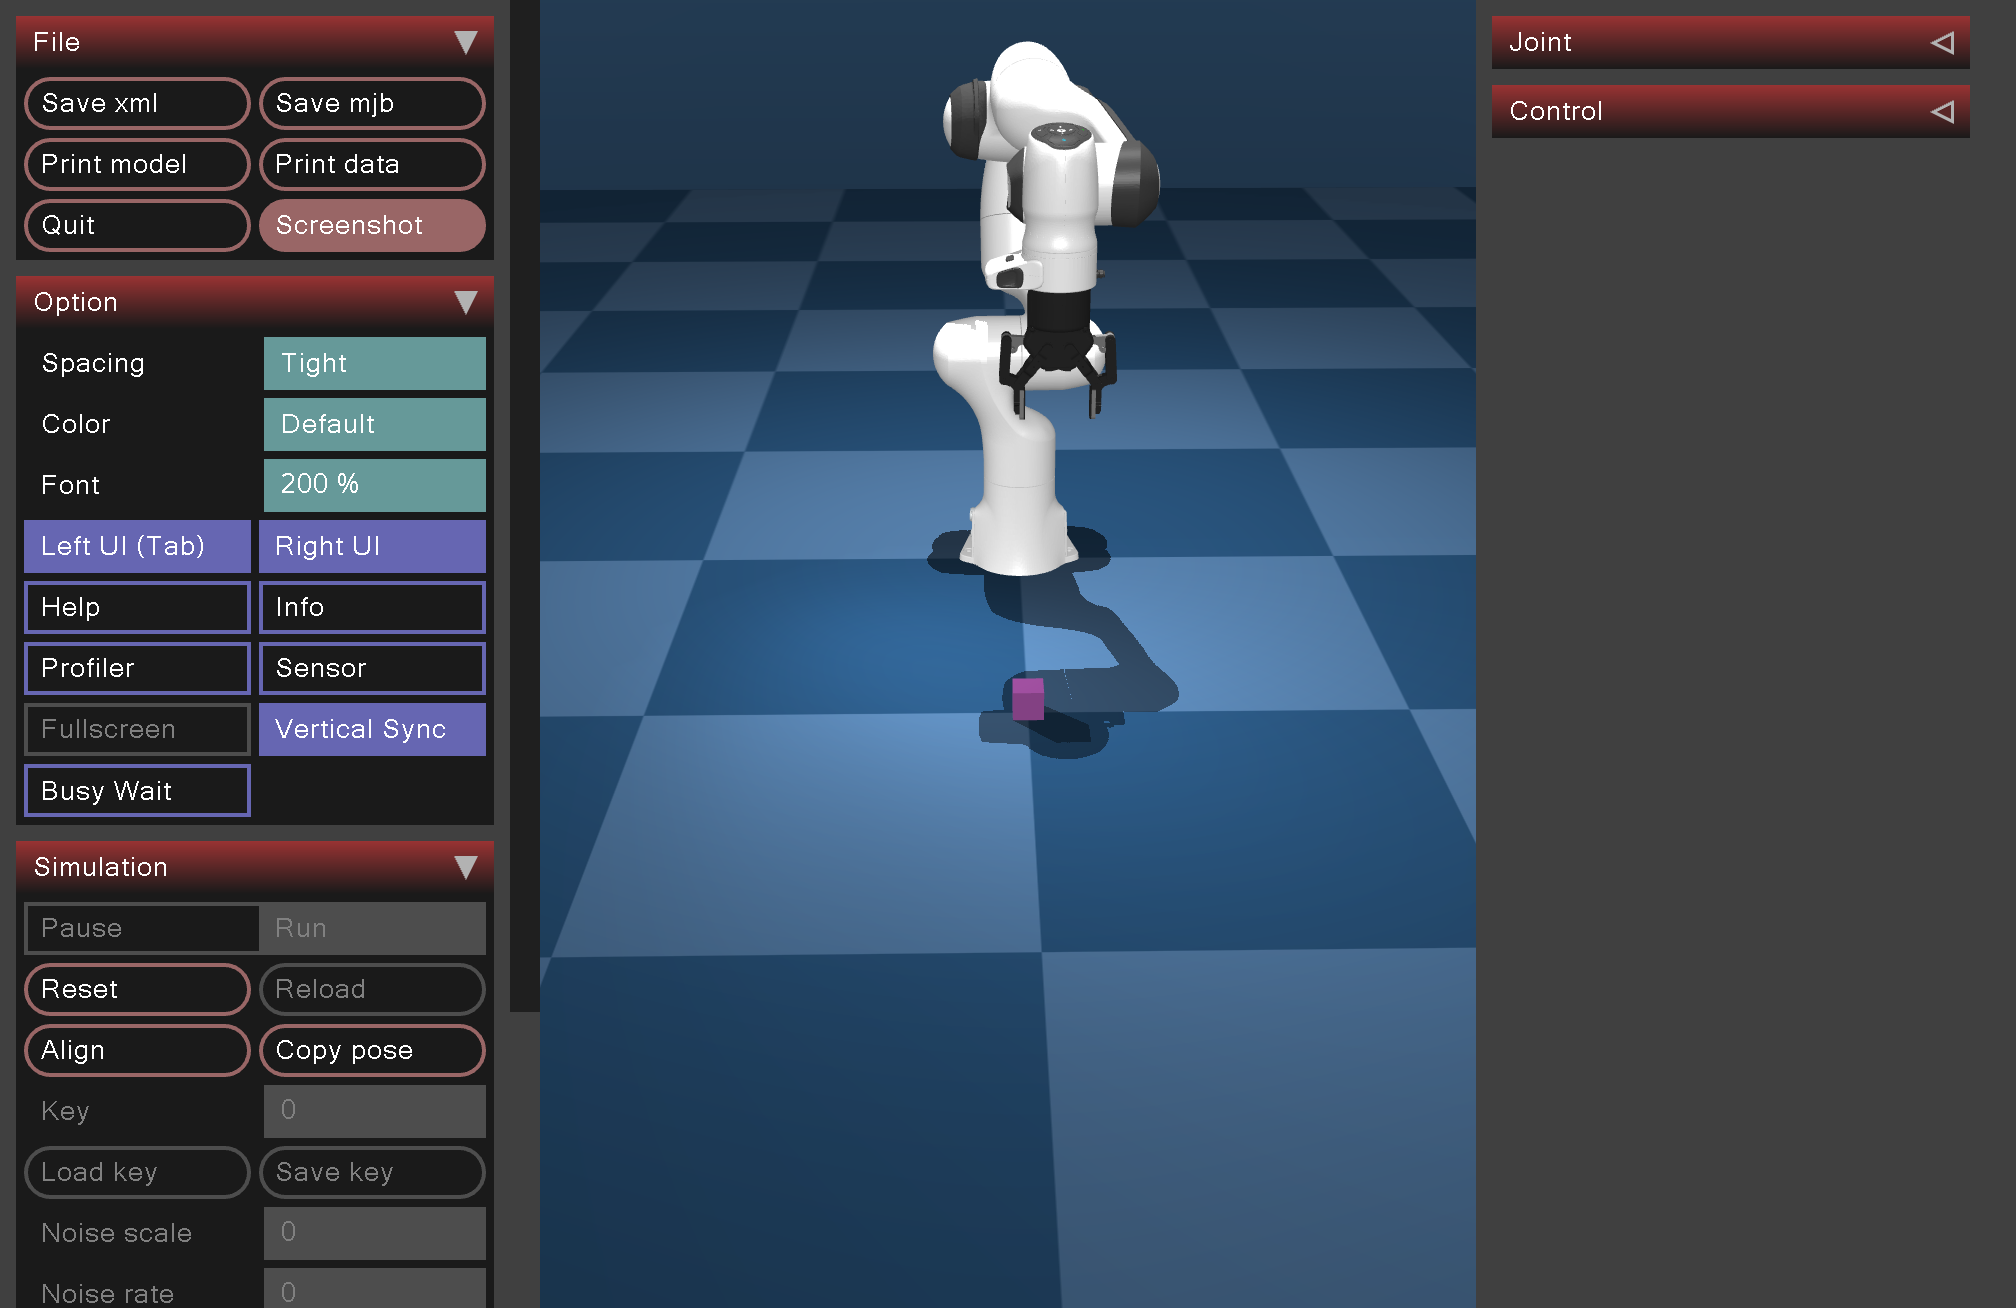

**Finetuned Model**

The finetuned model does a much better attempt. It still isn't very good as we never successfully picked up the cube. However, we actually manage to make contact with the cube in the majority of times and the arm is clearly attempting to try to grab. It comes very close.

Possibly we did not include enough training data (only 25 episodes) and also missed the text input embeddings. In the future, we should try both of these options and see if we can successffully grab the cube.

```bash
INFO:root:==================================================
INFO:root:EVALUATION SUMMARY OVER 10 EPISODES
INFO:root:==================================================
INFO:root:Episode Rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
INFO:root:Successful Episodes (reward > 0): 0.00%
INFO:root:--------------------------------------------------
INFO:root:Contact Made (T/F): [True, True, True, True, True, True, True, True, False, True]
INFO:root:Contact Rate: 90.00%
INFO:root:==================================================
```

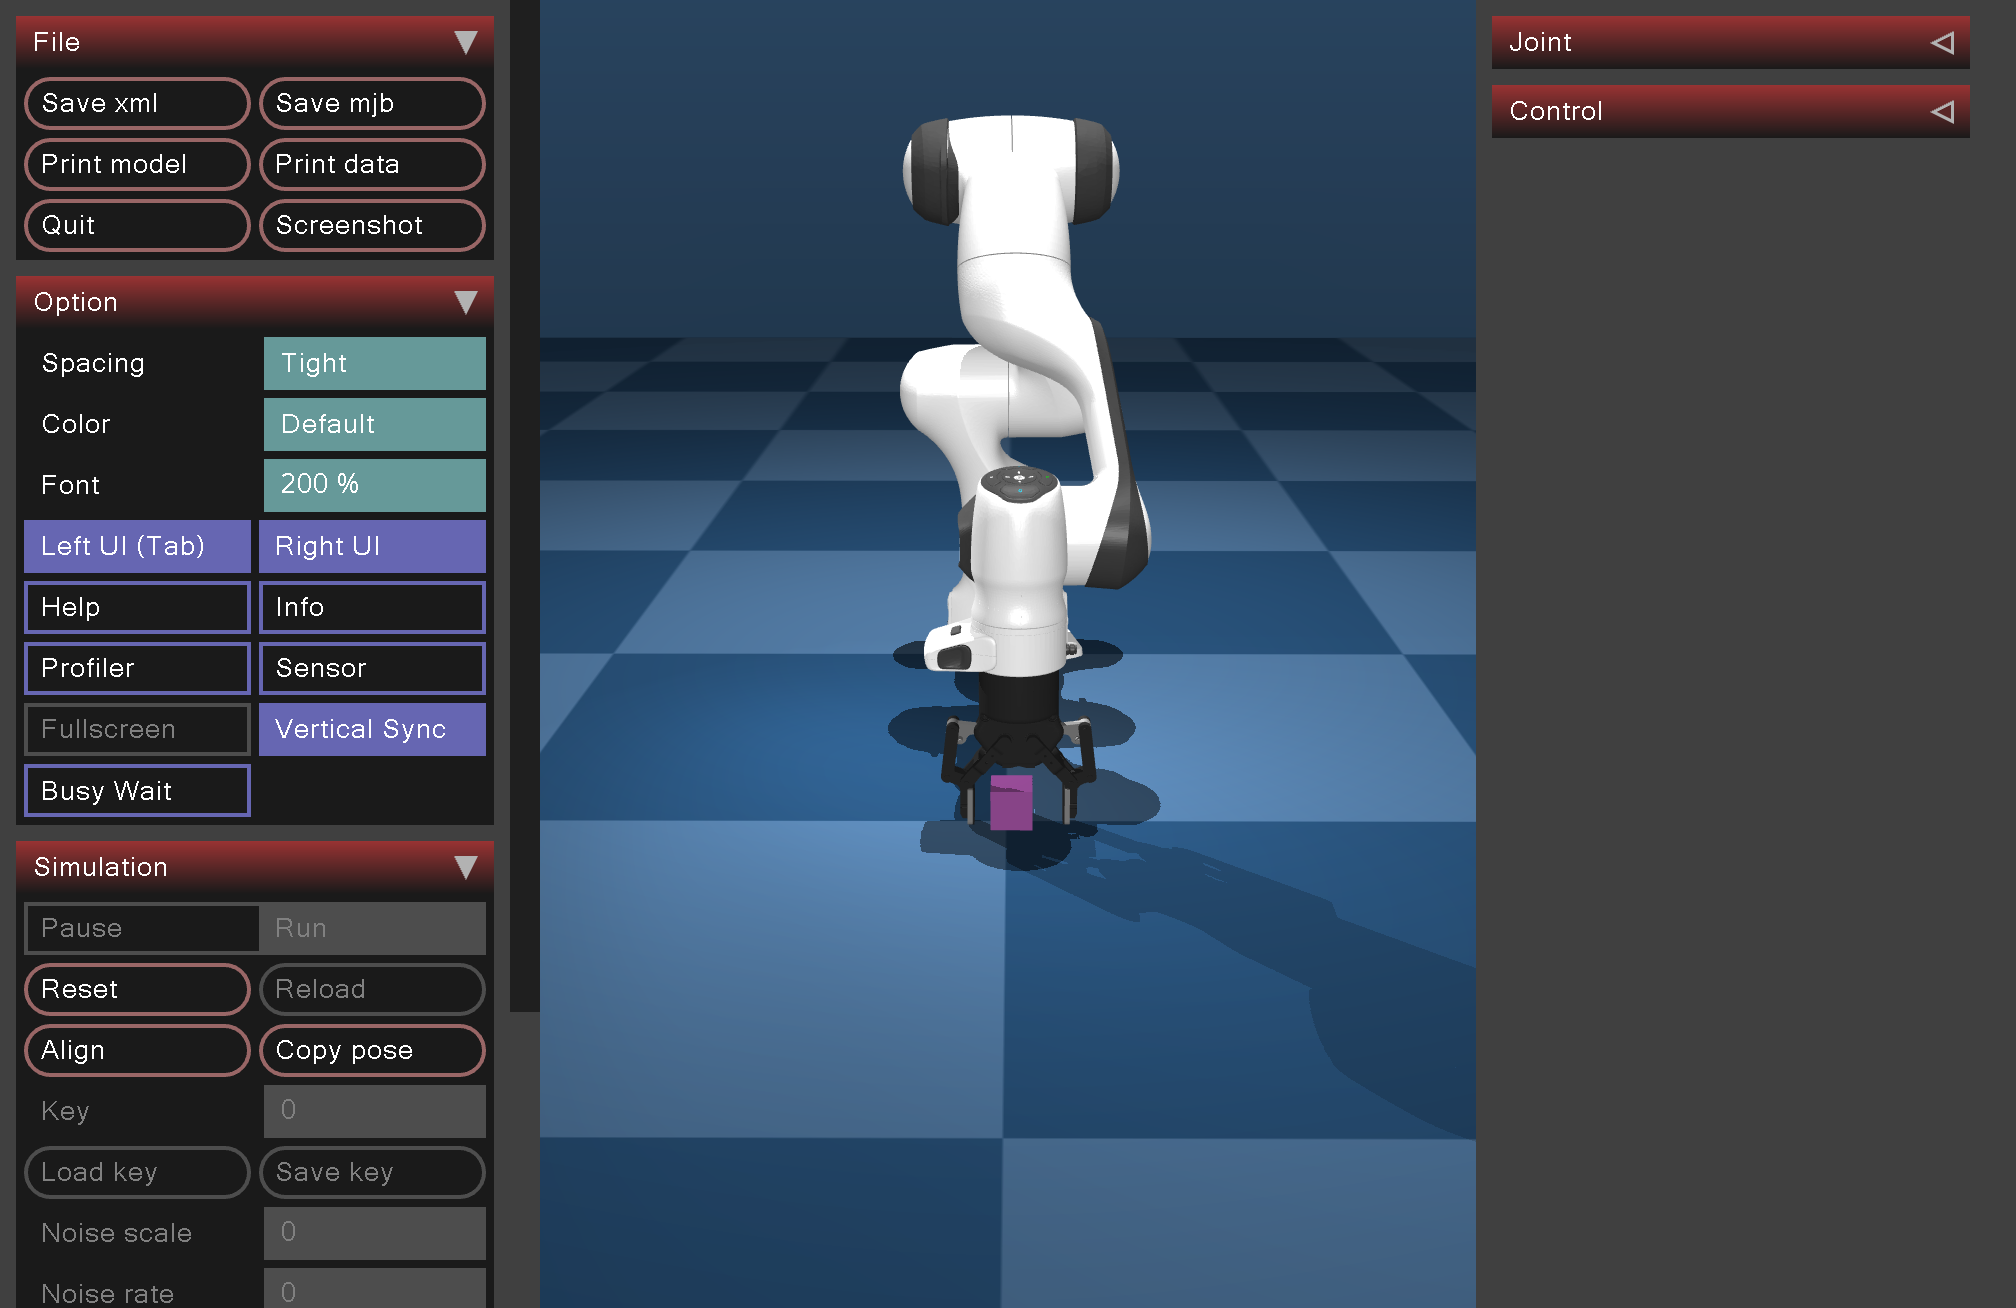

# Future Expansions

1. Getting Better at Picking the Cube
    - Our biggest next step is to add the text instruction "Pick up the cube" to our training data. The model was trying to move correctly but didn't know why because it wasn't trained with the text command.
    - We also used a very small dataset of only 25 episodes. Collecting more demonstration data will help the model see more examples of how to succeed. By training with more data that includes text instructions, the model should learn not just how to move, but what it's supposed to do.

2. Trying New Tasks in the Simulator
    - Once we have a good cube-picking policy, we can try more complex tasks. For example, we could teach the robot to stack one cube on top of another, or to open a small drawer.
    - For each new task, we would need to collect a new dataset and fine-tune our model with the new goal, like "stack the cubes." This would test if the model can learn different skills from demonstrations.

3. Moving to a Real Robot (Sim2Real)
    - The ultimate goal is to take what we learned in the simulator and use it on a real robot arm. This is hard because the real world is more messy than the simulation. Lighting changes, and object physics are slightly different.
    - To prepare the model, we can make the simulation harder during training. We can randomly change the lighting, table colors, and cube textures. This forces the model to learn a more robust strategy that doesn't rely on the perfect simulation. After training in the harder simulation, we would test the policy on the real robot and see how well it works